# Data Exploration

**Input**: Consumer_complaint_narrative

Example: “ I have outdated information on my credit report that I have previously disputed that has yet to be removed this information is more then seven years old and does not meet credit reporting requirements”

**Output**: product

Example: Credit reporting

Steps:
1. remove missing values in the “Consumer complaints narrative” column
2. add a column encoding the product as an integer
3. create a couple of dictionaries for future use


In [ ]:
import pandas as pd

df = pd.read_csv('./data.csv')

df['category_id'] = df['Product'].factorize()[0]
from io import StringIO
category_id_df = df[['Product', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Product']].values)

In [ ]:
df.head()

,Product,Consumer_complaint_narrative,category_id
0,"Credit reporting, credit repair services, or o...",I sent a letter by certified mail to TRANSUNIO...,0
1,"Credit reporting, credit repair services, or o...",I am very distressed that you have included th...,0
2,"Payday loan, title loan, or personal loan",About 4 years ago I went to get a personal loa...,1
3,"Credit reporting, credit repair services, or o...",My husband and I bought a new car in XX/XX/XXX...,0
4,Credit card or prepaid card,Early XX/XX/XXXX : Received an unsolicited inv...,2


# Imbalanced Classes


Number of complaints per product is imbalanced. Consumers’ complaints are more biased towards Debt collection, Credit reporting and Mortgage. 


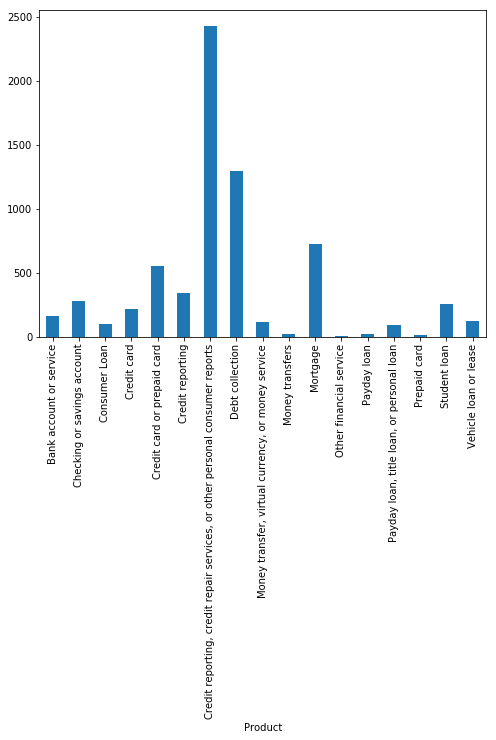

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('Product').Consumer_complaint_narrative.count().plot.bar(ylim=0)
plt.show()

# Text Representation

The classifiers and learning algorithms can not directly process the text documents in their original form, as most of them expect numerical feature vectors with a fixed size rather than the raw text documents with variable length. Therefore, during the preprocessing step, the texts are converted to a more manageable representation.
One common approach for extracting features from text is to use the bag of words model: a model where for each document, a complaint narrative in our case, the presence (and often the frequency) of words is taken into consideration, but the order in which they occur is ignored.


sublinear_df is set to True to use a logarithmic form for frequency.
min_df is the minimum numbers of documents a word must be present in to be kept.
norm is set to l2, to ensure all our feature vectors have a euclidian norm of 1.
ngram_range is set to (1, 2) to indicate that we want to consider both unigrams and bigrams.
stop_words is set to "english" to remove all common pronouns ("a", "the", ...) to reduce the number of noisy features.


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

features = tfidf.fit_transform(df.Consumer_complaint_narrative).toarray()
labels = df.category_id
features.shape

(6723, 19933)

Now, each of 6723 consumer complaint narratives is represented by 19933 features, representing the tf-idf score for different unigrams and bigrams.

In [ ]:
from sklearn.feature_selection import chi2
import numpy as np

N = 2
for Product, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(Product))
  print("  . Most correlated unigrams:\n       . {}".format('\n       . '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n       . {}".format('\n       . '.join(bigrams[-N:])))

# 'Bank account or service':
  . Most correlated unigrams:
       . bank
       . branch
  . Most correlated bigrams:
       . branch manager
       . overdraft fees
# 'Checking or savings account':
  . Most correlated unigrams:
       . deposited
       . atm
  . Most correlated bigrams:
       . savings account
       . checking account
# 'Consumer Loan':
  . Most correlated unigrams:
       . car
       . springleaf
  . Most correlated bigrams:
       . 72 months
       . total payments
# 'Credit card':
  . Most correlated unigrams:
       . target
       . card
  . Most correlated bigrams:
       . best buy
       . credit card
# 'Credit card or prepaid card':
  . Most correlated unigrams:
       . merchant
       . card
  . Most correlated bigrams:
       . american express
       . credit card
# 'Credit reporting':
  . Most correlated unigrams:
       . equifax
       . transunion
  . Most correlated bigrams:
       . report equifax
       . tax lien
# 'Credit reporting, credit r

# Training the Logistic Regression model



In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

from sklearn.model_selection import cross_val_score


models = [
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

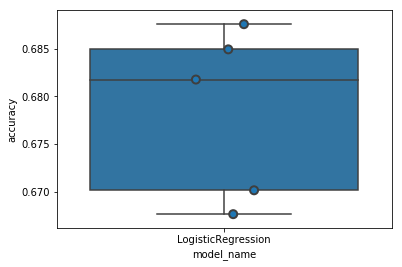

In [ ]:
import seaborn as sns

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [ ]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LogisticRegression    0.678405
Name: accuracy, dtype: float64

# Model Evaluation

Confusion matrix to show the discrepancies between predicted and actual labels. 


In [ ]:
from sklearn.model_selection import train_test_split

model = LogisticRegression(random_state=0)

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

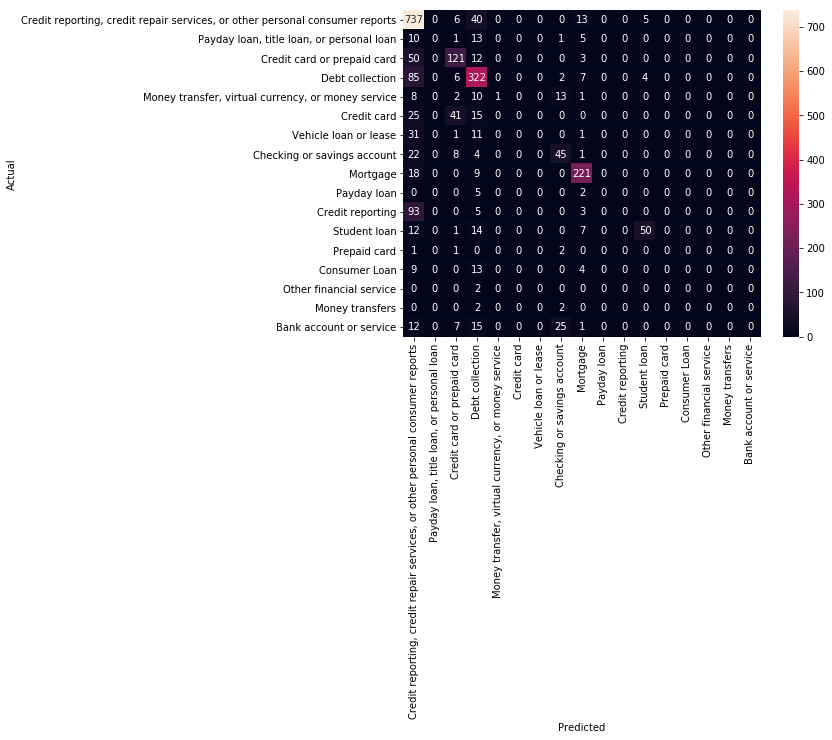

In [ ]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.Product.values, yticklabels=category_id_df.Product.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

The vast majority of the predictions end up on the diagonal (predicted label = actual label). There are a number of misclassifications, and it might be interesting to see what those are caused by:

In [ ]:
from IPython.display import display

for predicted in category_id_df.category_id:
  for actual in category_id_df.category_id:
    if predicted != actual and conf_mat[actual, predicted] >= 6:
      print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
      display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['Product', 'Consumer_complaint_narrative']])
      print('')

'Payday loan, title loan, or personal loan' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 10 examples.


,Product,Consumer_complaint_narrative
4920,"Payday loan, title loan, or personal loan",This is in response to file number XXXX. \nCom...
4234,"Payday loan, title loan, or personal loan",I received a check in the mail for XXXX dollar...
4063,"Payday loan, title loan, or personal loan",Payday loan has been taken from my bank and it...
4000,"Payday loan, title loan, or personal loan",Payday loans with this amount of interest or i...
2252,"Payday loan, title loan, or personal loan",The personal loan was originally with XXXX. XX...
2325,"Payday loan, title loan, or personal loan","To whom it may concern, Good afternoon, I hope..."
1224,"Payday loan, title loan, or personal loan",XXXX dollars for a XXXX dollar loan 780 percen...
1450,"Payday loan, title loan, or personal loan","I got a loan from DuveraXXXX XXXX, I paid for ..."
700,"Payday loan, title loan, or personal loan",In XXXX of 2018 Fifth Third Bank put a late pa...
4492,"Payday loan, title loan, or personal loan",Car broke down ( XXXX XXXX XXXX ) had already ...



'Credit card or prepaid card' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 50 examples.


,Product,Consumer_complaint_narrative
2323,Credit card or prepaid card,I requested a Balance Transfer from Discover t...
4624,Credit card or prepaid card,This particular account situation that is late...
6145,Credit card or prepaid card,CAPITAL ONE CREDIT CARD WAS OPENED IN MY NAME ...
3935,Credit card or prepaid card,I made a payment via ach Monday XX/XX/XXXX. Th...
1749,Credit card or prepaid card,I need access to my financial data in apps. Pl...
1957,Credit card or prepaid card,"Hello, Capital one has a business credit card ..."
475,Credit card or prepaid card,i am a victim of identity theft by the lasw of...
6532,Credit card or prepaid card,I see multiple 30 & 60-days late marks which i...
4233,Credit card or prepaid card,I have a closed account showing on my credit r...
3756,Credit card or prepaid card,"My father, XXXX XXXX XXXX and I have an accoun..."



'Debt collection' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 85 examples.


,Product,Consumer_complaint_narrative
3915,Debt collection,I had a collections account for a XXXX Charge ...
3955,Debt collection,I've sent multiple letters to this agency abou...
1082,Debt collection,XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX X...
5422,Debt collection,Hello. Back in 2013 I visited the XXXX XXXX XX...
4348,Debt collection,Diversified Consultants h ave placed on all ...
3166,Debt collection,I received 3 letters from XXXX Credit monitori...
1161,Debt collection,I contacted the credit reporting agency Torres...
1314,Debt collection,I consolidated all my Federal Student Loans wi...
5879,Debt collection,There have been a collection account placed wi...
5547,Debt collection,After reviewing my credit profile on XX/XX/XXX...



'Money transfer, virtual currency, or money service' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 8 examples.


,Product,Consumer_complaint_narrative
3476,"Money transfer, virtual currency, or money ser...",On XX/XX/2020 I attempted to add funds to the ...
6673,"Money transfer, virtual currency, or money ser...","On XXXX XXXX, 2020, I was at the XXXX XXXX XXX..."
2426,"Money transfer, virtual currency, or money ser...","I have money on hold through zelle and on "" XX..."
6234,"Money transfer, virtual currency, or money ser...",PNC Bank does not allow transfers between them...
861,"Money transfer, virtual currency, or money ser...",I own a small business that accepts credit car...
776,"Money transfer, virtual currency, or money ser...",They wont allow me to connect to another accou...
4714,"Money transfer, virtual currency, or money ser...",last month i went on line to my paypal account...
624,"Money transfer, virtual currency, or money ser...","Intentionally and deliberately, PayPal Inc, mi..."



'Credit card' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 25 examples.


,Product,Consumer_complaint_narrative
5614,Credit card,I setup an automatic pay for my Target credit ...
5242,Credit card,Identity theft
1835,Credit card,Two charges were placed on my bill on the same...
3840,Credit card,We were making payments to our credit card cap...
1624,Credit card,"I was at Kay Jewelers in XXXX XXXX, FL and the..."
1928,Credit card,"This account is reported in to XXXX, XXXX and ..."
4031,Credit card,CAPITAL ONE BANK USA ACCOUNT NUMBERs : XXXX XX...
1160,Credit card,Case id XXXX bank of americalast four : XXXX h...
3059,Credit card,"Discover card has reported me to XXXX, XXXX an..."
1984,Credit card,On XX/XX/XXXX I opened a credit card account w...



'Vehicle loan or lease' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 31 examples.


,Product,Consumer_complaint_narrative
3524,Vehicle loan or lease,"The contract dates, amounts and city are wrong..."
6309,Vehicle loan or lease,I have an auto loan with XXXX XXXX XXXX. It wa...
4800,Vehicle loan or lease,I am a current member of Penn Federal Credit U...
5933,Vehicle loan or lease,Collins Asset Group claims I owe them $XXXX fo...
1815,Vehicle loan or lease,I purchase a XXXX XXXX XXXXXXXX XXXX from XXXX...
3795,Vehicle loan or lease,I arranged a payment for my vehicle and the op...
1185,Vehicle loan or lease,"There are several issues with my auto loan, an..."
4993,Vehicle loan or lease,I am on auto pay and pay my entire lease bill ...
2601,Vehicle loan or lease,1.On XX/XX/XXXX I physically signed ( ink sign...
1246,Vehicle loan or lease,XX/XX/19 received letter in mail regarding den...



'Checking or savings account' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 22 examples.


,Product,Consumer_complaint_narrative
5409,Checking or savings account,I opened an IRA account in XX/XX/XXXX with XXX...
3382,Checking or savings account,WE OPENED 2 CREDIT CARDS WITH BANK OF AMERICA ...
5685,Checking or savings account,I am contacting Federal Reserve consumer ( con...
5042,Checking or savings account,Wells Fargo bank allowed XXXX $ of UNAUTHORIZE...
6390,Checking or savings account,Car accident Attorney XXXX XXXX XXXX Of XXXX X...
2038,Checking or savings account,a thief used a phony driver license to steal m...
6065,Checking or savings account,Account was closed by USAA for no reason and w...
479,Checking or savings account,I believe that I am a victim of fraud and /or ...
3063,Checking or savings account,"For my account ending in XXXX, SunTrust looked..."
2703,Checking or savings account,Some one hacked into my Regions Bank account a...



'Mortgage' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 18 examples.


,Product,Consumer_complaint_narrative
6666,Mortgage,Ocwen Loan Servicing has violated 12 CFR 226.1...
5799,Mortgage,I have had a HELOC with PNC Bank for many year...
3864,Mortgage,"I attempted to cancel an automatic payment, bu..."
976,Mortgage,I tried getting a personal loan with my credit...
6349,Mortgage,I contact a Shellpoint Mortgage Company custom...
5506,Mortgage,The house shows a volunteer repo i never agree...
2043,Mortgage,"In their response to complaint XXXX, Springlea..."
3375,Mortgage,AN UNKNOWN ERROR IS FALSELY REPORTING A 30 DAY...
1750,Mortgage,I entered into a hardship program with XXXX XX...
5292,Mortgage,For about the last 6 to 8 months Discover Bank...



'Credit reporting' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 93 examples.


,Product,Consumer_complaint_narrative
3325,Credit reporting,I have unauthorized and fraudulent inquiries a...
3007,Credit reporting,My credit report is showing the name XXXX XXXX...
287,Credit reporting,"All the major credit reporting agencies, Trans..."
4774,Credit reporting,I have a lot of fraudulent inquiries that are ...
4873,Credit reporting,I wrote to TransUnion in XX/XX/XXXX to dispute...
4763,Credit reporting,I filed a complaint stating that the Public Re...
5160,Credit reporting,I previously submitted a dispute regarding XXX...
3641,Credit reporting,I had requested a free credit report. I was un...
6323,Credit reporting,"Dear CFPB, I am having a problem with accessin..."
1843,Credit reporting,I was looking at my credit report and saw an a...



'Student loan' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 12 examples.


,Product,Consumer_complaint_narrative
6507,Student loan,XXXX parent plus loan..paid on time for 5.5 ye...
444,Student loan,MY STUDENT LOAN IS BEING REPORTED AS 120 DAYS ...
1411,Student loan,My monthly amount has steadily gone up. Every ...
4157,Student loan,"In XXXX, I got a loan with Wells Fargo a XXXX ..."
3369,Student loan,In 2006 I signed my student loan promissary no...
2527,Student loan,I was credited only seven qualifying loan forg...
3428,Student loan,Fed loan uses online address system. I never c...
1142,Student loan,Wells Fargo sold my loan to another provider (...
5843,Student loan,I recieve a loan from XXXX on XXXX \nCould not...
6324,Student loan,I have mailed a detailed letter to Navient und...



'Consumer Loan' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 9 examples.


,Product,Consumer_complaint_narrative
2433,Consumer Loan,"XXXX XXXX, XXXX The information below is the s..."
1220,Consumer Loan,This car was a total loss XX/XX/XXXX. The pay ...
4941,Consumer Loan,Ally Bank had an account for my XX/XX/XXXX XXX...
1900,Consumer Loan,"My complaint is with First Merit Bank ( XXXX, ..."
5194,Consumer Loan,The prospective loan company financing a new c...
1804,Consumer Loan,JPMORGAN CHASE is reporting my auto loan erron...
6367,Consumer Loan,"It was brought to my attention that a "" Negati..."
6409,Consumer Loan,XXXX XXXX MILES ( XXXX MINUTES ) FROM AIRPORT ...
4891,Consumer Loan,I leased a car from ALLY Bank and was charged ...



'Bank account or service' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 12 examples.


,Product,Consumer_complaint_narrative
4595,Bank account or service,I received an offer to apply for a Citibank Ci...
2262,Bank account or service,I would like to add to my complaint ( case num...
6289,Bank account or service,my applying to open the account of First Tenne...
4841,Bank account or service,Wells Fargo ( WF ) was my bank for a period of...
1277,Bank account or service,I over drafted my account but was charged over...
1065,Bank account or service,Here is the letter i sent it to the bank throu...
1922,Bank account or service,I had my bank card stolen and my account was o...
4848,Bank account or service,I have a corporate bank account with Citibank....
6357,Bank account or service,XXXX XXXX had my child support payments deposi...
6202,Bank account or service,This complaint goes in hand with Complaint # X...



'Credit reporting, credit repair services, or other personal consumer reports' predicted as 'Credit card or prepaid card' : 6 examples.


,Product,Consumer_complaint_narrative
148,"Credit reporting, credit repair services, or o...",On XXXX / XXXX / 2016 I paid {$29.00} to go ...
4811,"Credit reporting, credit repair services, or o...",In XX/XX/XXXX I needed a credit card to use to...
1369,"Credit reporting, credit repair services, or o...",I was two days past the XX/XX/XXXX due date pa...
6163,"Credit reporting, credit repair services, or o...",I was shocked when I reviewed my credit report...
5987,"Credit reporting, credit repair services, or o...",I recently settled the amount that Bank of Ame...
5281,"Credit reporting, credit repair services, or o...",I was shocked when I reviewed my credit report...



'Debt collection' predicted as 'Credit card or prepaid card' : 6 examples.


,Product,Consumer_complaint_narrative
526,Debt collection,Now I am being charged by Experian for a bogus...
6275,Debt collection,This concerns my BBVA Compass credit card endi...
5782,Debt collection,"commerce bank credit card, was original credit..."
5336,Debt collection,"self employed, hit hard times and mistake in c..."
4018,Debt collection,in XXXX XXXX i ordered items from roamans clot...
5388,Debt collection,I received a call from CITI bank regarding my ...



'Credit card' predicted as 'Credit card or prepaid card' : 41 examples.


,Product,Consumer_complaint_narrative
5961,Credit card,Barclay Card Servicing is the worse card servi...
2830,Credit card,I have a Best Buy Credit Card which is run and...
4910,Credit card,I was charged by XXXX for classes that I did n...
2425,Credit card,I apply for an American Express Platinum card ...
842,Credit card,Unexpectedly I received a new Chase Amazon Rew...
737,Credit card,I applied for American Express Delta Gold Skym...
3710,Credit card,I had my identity stolen and several Credit Ca...
4024,Credit card,The surge card I got double charge me maintena...
1087,Credit card,XX/XX/XXXX during the Holiday season Walmart a...
578,Credit card,"My due date was on a Sunday, XXXX/XXXX/16. The..."



'Checking or savings account' predicted as 'Credit card or prepaid card' : 8 examples.


,Product,Consumer_complaint_narrative
2640,Checking or savings account,XX/XX/XXXX early in the morning lost my debit ...
4446,Checking or savings account,"On XX/XX/2018, I had attempted to get a taxi f..."
2229,Checking or savings account,On XX/XX/XXXX I signed up for a security monit...
880,Checking or savings account,Claim XXXX Wells Fargo XXXX wellsfargo card cl...
1255,Checking or savings account,On XX/XX/XXXX I submitted a stop payment reque...
3587,Checking or savings account,Applied for a new account on XX/XX/18. I recei...
4429,Checking or savings account,M & T Bank Claim Number # XXXX. I called and d...
1763,Checking or savings account,I opened a checking account with the PNC XXXX ...



'Bank account or service' predicted as 'Credit card or prepaid card' : 7 examples.


,Product,Consumer_complaint_narrative
2824,Bank account or service,This may also be a credit card complaint. I wa...
3162,Bank account or service,We have a small business as a gallery for 55 y...
5527,Bank account or service,BMO Harris issued me a new chip debit card to ...
4559,Bank account or service,RushCard sent out a message that they were upd...
2571,Bank account or service,We are told by the banks issuing credit cards ...
1248,Bank account or service,I recently realise on my Best Buy c.c. That i ...
4061,Bank account or service,Chase keeps denying the use of my debit card a...



'Credit reporting, credit repair services, or other personal consumer reports' predicted as 'Debt collection' : 40 examples.


,Product,Consumer_complaint_narrative
1669,"Credit reporting, credit repair services, or o...",In my reports a closed account with huge amoun...
6541,"Credit reporting, credit repair services, or o...",I had an outstanding balance on an account wit...
3936,"Credit reporting, credit repair services, or o...",Please note I sent a dispute with XXXX and the...
1136,"Credit reporting, credit repair services, or o...",This company charged me an high interests and ...
1554,"Credit reporting, credit repair services, or o...",Complaint was filed with Consumer Financial Pr...
5348,"Credit reporting, credit repair services, or o...",I've mention in the previous certified letters...
1601,"Credit reporting, credit repair services, or o...",XXXX XXXX card is harrassing and placing false...
2272,"Credit reporting, credit repair services, or o...",There is a collection with XXXX XXXX reporting...
2559,"Credit reporting, credit repair services, or o...",Send several certified letters with tracking n...
6091,"Credit reporting, credit repair services, or o...",I rented an apartment at XXXX XXXX XXXX XXXX &...



'Payday loan, title loan, or personal loan' predicted as 'Debt collection' : 13 examples.


,Product,Consumer_complaint_narrative
4379,"Payday loan, title loan, or personal loan",I received a personal loan back In XXXX for XX...
5392,"Payday loan, title loan, or personal loan",On XX/XX/18 I contacted Tower Loan in XXXX XXX...
6645,"Payday loan, title loan, or personal loan","XX/XX/2018, I called American First Finance ab..."
6584,"Payday loan, title loan, or personal loan",Called their customer service phone number Tue...
2564,"Payday loan, title loan, or personal loan",Hi - I have several synchrony bank loans that ...
4441,"Payday loan, title loan, or personal loan",XX/XX/XXXX I took out a loan/line of credit wi...
3498,"Payday loan, title loan, or personal loan","XXXX has recently contacted me, telling me tha..."
3993,"Payday loan, title loan, or personal loan",I took out a loan in XXXX. I am elderly and on...
4603,"Payday loan, title loan, or personal loan",I received a loan for $ XXXX {$800.00} from 1s...
282,"Payday loan, title loan, or personal loan",I paid big picture loan ahead of time to avoid...



'Credit card or prepaid card' predicted as 'Debt collection' : 12 examples.


,Product,Consumer_complaint_narrative
4999,Credit card or prepaid card,My wife opened a credit card in her name and h...
1828,Credit card or prepaid card,I was introduced to the idea of borrowing mone...
2836,Credit card or prepaid card,"Today, XXXX/XXXX/19, I arrived home and found ..."
2709,Credit card or prepaid card,My husband and I lost our jobs last year and h...
729,Credit card or prepaid card,"I ordered a bed, and nightstand from XXXX on X..."
6283,Credit card or prepaid card,"I have repeatedly disputed this account, the c..."
2092,Credit card or prepaid card,I opened an account in XXXX of XXXX as a...
3618,Credit card or prepaid card,To : Capital One XXXX XXXX XXXX XXXX XXXX XXXX...
534,Credit card or prepaid card,I have been a bluebird American Express client...
3586,Credit card or prepaid card,I called to close the account and asked for a ...



'Money transfer, virtual currency, or money service' predicted as 'Debt collection' : 10 examples.


,Product,Consumer_complaint_narrative
1568,"Money transfer, virtual currency, or money ser...",I have signed up for a service through XXXX ...
4643,"Money transfer, virtual currency, or money ser...","On XX/XX/XXXX, I made a {$200.00} transfer thr..."
1270,"Money transfer, virtual currency, or money ser...","I went to DolEx express at XXXX meat market, X..."
3994,"Money transfer, virtual currency, or money ser...",My complaint is with M & T and their lack of c...
5737,"Money transfer, virtual currency, or money ser...",Coinbase XXXX # XXXX Coinbase / XXXX have susp...
4853,"Money transfer, virtual currency, or money ser...",I went to XXXX in XXXX In where a employee of ...
2429,"Money transfer, virtual currency, or money ser...","On Saturday, XX/XX/XXXX, around XXXX I began a..."
6078,"Money transfer, virtual currency, or money ser...",I have two Certificates of Deposit dated XX/XX...
4436,"Money transfer, virtual currency, or money ser...","paypal steal my money, They took the money out..."
5327,"Money transfer, virtual currency, or money ser...",I am trying to close my PayPal account associa...



'Credit card' predicted as 'Debt collection' : 15 examples.


,Product,Consumer_complaint_narrative
3439,Credit card,I was suggested this card from my dental care....
1593,Credit card,HELLO. \nTHIS PARAGRAPH IS SUPLIMENTAL TO THE ...
1196,Credit card,Ever since XXXX XXXX has joined with the colle...
1811,Credit card,On XX/XX/2017 I mailed a letter in response to...
3931,Credit card,On XXXX/XXXX/2015 I purchased a refrigerator f...
1330,Credit card,"Opened Capital One Bank account in XXXX, 17 ye..."
5301,Credit card,Eleven years ago I lost my job then had a prob...
2707,Credit card,I had a family death of my mother and she is i...
4834,Credit card,"In XXXX of XXXX, I opened an account with Citi..."
3991,Credit card,On XXXX/XXXX/14 I opened an account with Synch...



'Vehicle loan or lease' predicted as 'Debt collection' : 11 examples.


,Product,Consumer_complaint_narrative
4855,Vehicle loan or lease,"Since XX/XX/XXXX, I have been trying to get a ..."
1267,Vehicle loan or lease,This is emails in which I have submitted to Al...
2182,Vehicle loan or lease,It is about a XXXX car that I no longer have. ...
6244,Vehicle loan or lease,In XX/XX/XXXX we were approved for a holiday p...
949,Vehicle loan or lease,My vehicle loan was being serviced by XXXX XXX...
6067,Vehicle loan or lease,XX/XX/XXXX : called Toyota to do a voluntary r...
5910,Vehicle loan or lease,I RECEIVED A LETTER IN XXXX REGARDING THE WELL...
5634,Vehicle loan or lease,Called ally finance about gap and warranty pro...
854,Vehicle loan or lease,I had filed a complaint previously. The banks ...
4888,Vehicle loan or lease,"I have a lease with Ally Bank, my vehicle was ..."



'Mortgage' predicted as 'Debt collection' : 9 examples.


,Product,Consumer_complaint_narrative
1974,Mortgage,Asked in writing that my PMI be canceled and a...
4937,Mortgage,After being told that my number was being take...
2235,Mortgage,On XX/XX/XXXX the check we wrote that paid the...
2971,Mortgage,Wednesday XX/XX/XXXX : New American Funding st...
2529,Mortgage,Re : erroneous item XXXX XXXX XXXX # XXXX repo...
5762,Mortgage,I purchased a home XX/XX/2020 and Midwest Loan...
6525,Mortgage,This is a disputed response to previously file...
3374,Mortgage,Im asking this agency to investigate this tria...
3669,Mortgage,We updated our mortgage auto payment online an...



'Student loan' predicted as 'Debt collection' : 14 examples.


,Product,Consumer_complaint_narrative
3731,Student loan,I am XXXX XXXX XXXX and XXXX XXXX veteran due ...
170,Student loan,I have XXXX loan which has the same account nu...
994,Student loan,My original payment was set at {$50.00} around...
4406,Student loan,I went out on XXXX form school and NelNet pick...
5233,Student loan,I have contacted FEDLOAN on numerous occasions...
2647,Student loan,I keep getting calls from this number ( XXXX )...
66,Student loan,"Earlier this month, my payment was increased f..."
2132,Student loan,I have been contacting Action Financial servic...
977,Student loan,Company has repeatedly mismanaged {$430000.00}...
5608,Student loan,XXXX XXXX University offered me a No payments ...



'Consumer Loan' predicted as 'Debt collection' : 13 examples.


,Product,Consumer_complaint_narrative
2984,Consumer Loan,Our son purchased a vehicle and had it finance...
4519,Consumer Loan,On XX/XX/2015 I went to the Car Max dealership...
6647,Consumer Loan,Checking my credit without my permission. Also...
6169,Consumer Loan,hyundai finance uses discriminatory tactics to...
6537,Consumer Loan,I purchased a computer through Conn 's utilizi...
5550,Consumer Loan,"Harassment, Trying to collect more than owed, ..."
4396,Consumer Loan,The branch office filing lawsuits in magistrat...
6698,Consumer Loan,Harley Davidson is calling the office for debt...
1597,Consumer Loan,I am currently making payments to Automobile A...
6721,Consumer Loan,"hello my name is XXXX XXXX, and I was aggressi..."



'Bank account or service' predicted as 'Debt collection' : 15 examples.


,Product,Consumer_complaint_narrative
5096,Bank account or service,Us Bank charged me fees for items that cleared...
4965,Bank account or service,"Hello, I been with Well Fargo for so many year..."
2355,Bank account or service,I would like to lodge a formal complaint about...
4309,Bank account or service,The representatives of XXXX went to Wells Farg...
1892,Bank account or service,I am being stalked by a US Bank employee who c...
4557,Bank account or service,I was attempting to move money from my PayPal ...
1778,Bank account or service,I was frauded against and when I filed a claim...
3831,Bank account or service,I contacted Wells Fargo to request XXXX checks...
2189,Bank account or service,I got restriction with my bank Capitol One 360...
5965,Bank account or service,# 1 -- PayPal/Ebay Inc Auction where as XXXX t...



'Money transfer, virtual currency, or money service' predicted as 'Checking or savings account' : 13 examples.


,Product,Consumer_complaint_narrative
4330,"Money transfer, virtual currency, or money ser...",I sent a wire with below details and i was tol...
472,"Money transfer, virtual currency, or money ser...",I had a balance of {$1700.00} in my Venmo acco...
5459,"Money transfer, virtual currency, or money ser...",I have an account with Coinbase and have XXXX ...
6608,"Money transfer, virtual currency, or money ser...","On XX/XX/ 2020, I tried to send money using In..."
3266,"Money transfer, virtual currency, or money ser...",On XXXX XX/XX/2020. i made an attempt to trans...
5083,"Money transfer, virtual currency, or money ser...","XX/XX/19, {$460.00} - rental scam. I found a r..."
5451,"Money transfer, virtual currency, or money ser...",On XX/XX/2020 I transferred {$500.00} from my ...
4213,"Money transfer, virtual currency, or money ser...",I am having an issue with Coinbase and was adv...
3241,"Money transfer, virtual currency, or money ser...","On XX/XX/2019, I met with Detective XXXX XXXX,..."
893,"Money transfer, virtual currency, or money ser...","On XX/XX/2016, my colleague XXXX XXXX and I en..."



'Bank account or service' predicted as 'Checking or savings account' : 25 examples.


,Product,Consumer_complaint_narrative
6248,Bank account or service,Astoria Bank charged me an overdraft fee after...
2345,Bank account or service,Issue 1 - Events : XXXX. There were many fraud...
4762,Bank account or service,I opened a Huntington checking acct because of...
4578,Bank account or service,Today is XX/XX/2016 After me receiving my dire...
302,Bank account or service,I paid off my loan with ally bank back in XXXX...
4812,Bank account or service,I recently contacted Bank Of America for a dis...
2134,Bank account or service,"At a Well 's Fargo Bank, I moved money from my..."
3690,Bank account or service,"In XXXX 2016, I was prompted to open a Citiban..."
1290,Bank account or service,"Hello, After receiving a promotional offer cod..."
5888,Bank account or service,I met with a financial counselor who checked m...



'Credit reporting, credit repair services, or other personal consumer reports' predicted as 'Mortgage' : 13 examples.


,Product,Consumer_complaint_narrative
6660,"Credit reporting, credit repair services, or o...",Loancare the mortgage servicer of my loan sold...
2534,"Credit reporting, credit repair services, or o...",Freedom mortgage is the institution who is res...
533,"Credit reporting, credit repair services, or o...",GMAC Mortgage company is reporting a bankruptc...
6063,"Credit reporting, credit repair services, or o...","After trying to work directly with One Main, I..."
3992,"Credit reporting, credit repair services, or o...","On XX/XX/2015, I submitted payment for my XXXX..."
2550,"Credit reporting, credit repair services, or o...",XXXX XXXX keeps sending my check back to me th...
1380,"Credit reporting, credit repair services, or o...","On XXXX XXXX, XXXX we were contacted by an att..."
5833,"Credit reporting, credit repair services, or o...",Never applyed for a refinance loan with any of...
452,"Credit reporting, credit repair services, or o...",Specialized Loan Servicing currently reports a...
4318,"Credit reporting, credit repair services, or o...","XXXX XXXX XXXX sold my mortgage to Nationstar,..."



'Debt collection' predicted as 'Mortgage' : 7 examples.


,Product,Consumer_complaint_narrative
5257,Debt collection,"XXXX 2007, I signed for a {$260000.00} convent..."
88,Debt collection,On XX/XX/XXXX I sent a letter to SLS ( Special...
3701,Debt collection,Violations of numerous Federal and State Laws ...
4473,Debt collection,"As displayed within a "" Monthly Mortgage State..."
1206,Debt collection,"Dear CFPB, ( cc : Office of Comptroller of the..."
3225,Debt collection,I own an investment property and at one point ...
5773,Debt collection,"XXXX, XXXX XXXX XXXX true and lawful Attorney-..."



'Student loan' predicted as 'Mortgage' : 7 examples.


,Product,Consumer_complaint_narrative
6554,Student loan,I have been enrolled with automatic monthly pa...
3535,Student loan,"Got a school loan back in XX/XX/XXXX, XX/XX/XX..."
6446,Student loan,XXXX has not reviewed the recertification docu...
4189,Student loan,I'm trying to pay off a loan balance of XXXX (...
5857,Student loan,Nelnet is servicing my loan. The loan was guar...
2423,Student loan,I have completed the 120 months required for P...
4868,Student loan,"I would like to report PHEAAs unfair, deceptiv..."
